In [469]:
# python typical
import numpy as np
import matplotlib.pyplot as plt
import copy
from typing import List, Dict, Optional
from enum import Enum, IntEnum, auto
from dataclasses import dataclass

# tensor flow
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense

# python debugger
from icecream import ic # Debugger

Each row of this data file has its first entry as the product label (class). 
The remaining elements are the thirteen constituents of the 
product (they are the input data) for that sample. All entries in each row are 
separated by commas.







In [470]:
### IMPORT DATA ###
DATA = np.loadtxt(open("randomized_data.txt"), delimiter=",")

In [471]:
### DATA LABEL DEF ###
class Constituents(IntEnum):
    Ethanol                       = 1
    Malic_acid                    = 2 
    Ash                           = 3
    Alcalinity_of_ash             = 4 
    Magnesium                     = 5
    Total_phenols                 = 6
    Flavanoids                    = 7
    Nonflavanoid_phenols          = 8
    Proanthocyanins               = 9
    Color_intensity               = 10
    Hue                           = 11
    OD280_OD315_of_diluted_liquid = 12
    Proline                       = 13

class Product(IntEnum):
    P1 = 1
    P2 = 2
    P3 = 3   

class DataType(Enum):
    TRAIN_X = "train_x"
    TRAIN_Y = "train_y"
    TEST_X = "test_x"
    TEST_Y = "test_y"

In [472]:
### DATA EXTRACTION ###
# param:
Eta_train = 0.75 # 75% of data used for training

# find normalization bound
DATA_MIN_MAX = []
for entry in Constituents:
    DATA_MIN_MAX.append([min(DATA[:, entry]), max(DATA[:, entry])])
DATA_MIN_MAX = np.array(DATA_MIN_MAX)

# categorize by product class 
DATA_SET = {
    DataType.TRAIN_X  : [],
    DataType.TRAIN_Y  : [],
    DataType.TEST_X   : [],
    DataType.TEST_Y   : []
}

for prod in Product:
    # dataset categorization
    data = (DATA[DATA[:,0] == prod, 1:(len(Constituents)+1)])
    # dataset normalization
    data_norm = (data - DATA_MIN_MAX[:,0])/(DATA_MIN_MAX[:,1] - DATA_MIN_MAX[:,0])
    # dataset divide 
    n, m = np.shape(data_norm)
    n_train = round(n * Eta_train)
    # gen labels [ k , # Products ]
    Y_label = np.zeros((n, len(Product)))
    Y_label[:, prod - 1] = 1
    # store inputs
    DATA_SET[DataType.TRAIN_X].append( data_norm[0:n_train , :] )
    DATA_SET[DataType.TEST_X ].append( data_norm[n_train:n , :] )
    # store label
    DATA_SET[DataType.TRAIN_Y].append( Y_label[0:n_train , :] )
    DATA_SET[DataType.TEST_Y ].append( Y_label[n_train:n , :] )

DATA_SET[DataType.TRAIN_X] = np.concatenate(DATA_SET[DataType.TRAIN_X])
DATA_SET[DataType.TRAIN_Y] = np.concatenate(DATA_SET[DataType.TRAIN_Y])
DATA_SET[DataType.TEST_X ] = np.concatenate(DATA_SET[DataType.TEST_X ])
DATA_SET[DataType.TEST_Y ] = np.concatenate(DATA_SET[DataType.TEST_Y ])


In [473]:
# check data shape
ic(np.shape(DATA_SET[DataType.TRAIN_X]))
ic(np.shape(DATA_SET[DataType.TRAIN_Y]))
ic(np.shape(DATA_SET[DataType.TEST_X]))
ic(np.shape(DATA_SET[DataType.TEST_Y]))

ic| np.shape(DATA_SET[DataType.TRAIN_X]): (133, 13)
ic| np.shape(DATA_SET[DataType.TRAIN_Y]): (133, 3)
ic| np.shape(DATA_SET[DataType.TEST_X]): (45, 13)
ic| np.shape(DATA_SET[DataType.TEST_Y]): (45, 3)


(45, 3)

In [474]:
mlp = keras.models.Sequential([
  Dense(10, activation='sigmoid', input_shape=(13,)),
  Dense(20, activation='sigmoid'),
  Dense(3, activation='softmax')
])

print(mlp.summary())
mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_170 (Dense)            (None, 10)                140       
_________________________________________________________________
dense_171 (Dense)            (None, 20)                220       
_________________________________________________________________
dense_172 (Dense)            (None, 3)                 63        
Total params: 423
Trainable params: 423
Non-trainable params: 0
_________________________________________________________________
None


In [475]:
h = mlp.fit(
    DATA_SET[DataType.TRAIN_X], 
    DATA_SET[DataType.TRAIN_Y], 
    epochs=200, 
    batch_size=20, 
    validation_split=0.10, # 10% as the validation set to monitor the performance.
    verbose=0
)


train acc: 99.16 % 
val acc: 100.00 %


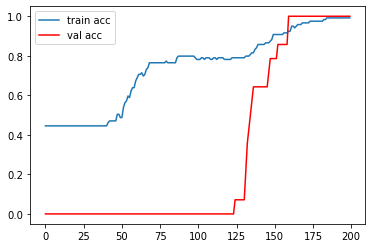

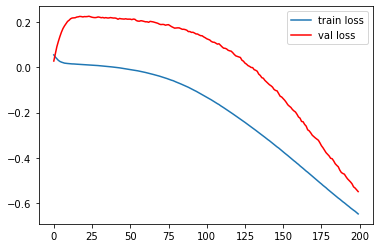

In [476]:
# Plot
plt.figure()
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'], 'r')
plt.legend(['train acc', 'val acc'])
print('train acc: %.2f %% \nval acc: %.2f %%'%(h.history['accuracy'][-1]*100,h.history['val_accuracy'][-1]*100))

plt.figure()
plt.plot(np.log10(h.history['loss']))
plt.plot(np.log10(h.history['val_loss']), 'r')
plt.legend(['train loss', 'val loss'])

fig2 = plt.gcf()
fig2.savefig("fig/test_{tag}.png".format(tag="idk"), bbox_inches = 'tight')

In [477]:
print('Test accuracy: %.2f %%'%(100*mlp.evaluate(DATA_SET[DataType.TEST_X],DATA_SET[DataType.TEST_Y], verbose=0)[1]))

Test accuracy: 95.56 %
